# Requirements
First, we import all the packages and modules we need for our pipeline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.grid_search import GridSearchCV

# Suppress scientific notation of float numbers in numpy arrays.
np.set_printoptions(suppress=True)

# Raw Material
First, we retrieve our training and test datasets from the csv files provided by Kaggle and store them in Pandas DataFrame objects.

In [2]:
train = pd.read_csv('../../data/train_original.csv')
test_kaggle = pd.read_csv('../../data/test_original.csv')

print 'train:', train.shape
print 'test:', test_kaggle.shape

train: (1460, 81)
test: (1459, 80)


In [3]:
print 'train:', train.shape
print 'test:', test_kaggle.shape

train: (1460, 81)
test: (1459, 80)


For later use, we store the feature labels of our training data in two variables, separated by categorical and continious features. Additionally, we store the label of our target variable (SalePrice).

In [4]:
CAT_VARS = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
            'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
            'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
            'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
            'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
            'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
            'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
            'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
            'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
            'MoSold', 'SaleType', 'SaleCondition']
CONT_VARS = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
             'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
             'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
             'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
             'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
             'PoolArea', 'MiscVal', 'YrSold']

TARGET_VAR = ['SalePrice', ]

# Preprocessing
The house IDs are currently saved in the datasets as ordinary columns. Pandas, however, allows for explicitely specifying indeces, i.e. row labels (much like our feature/column labels). The following makes sure we use our own IDs as indeces.

In [5]:
train.set_index('Id', inplace=True)
test_kaggle.set_index('Id', inplace=True)

The data contains of both categorial and continuous values. The following makes sure Pandas knows about this distinction and does not confuse the two by explicetely defining categorial features as such.

In [6]:
for cat_var in CAT_VARS:
    train[cat_var].astype('category')

Some prediction models require continuous features only. Thus, dummify() converts categorial features with *m* different possible classes into *m* new features (columns) – one feature for each class. These dummified features are either 1 or 0. 

For clarification of what's happening, consider the following example:

| Id | Street | → | Street_Gravel | Street_Paved |
|----|--------|---|---------------|--------------|
| 1  | Gravel | → | 1             | 0            |
| 2  | Paved  | → | 0             | 1            |
| 3  |        | → | 0             | 0            |
| 4  | Paved  | → | 0             | 1            |

We apply this dummification both to our training and to our test data. A nice side effect of that is that we do not have to deal with missing categorical values – they are simply set 0 in all the dummy columns (as shown in house 3 of the above example).

In [7]:
def dummify(data, update_cat_vars=False):
    # This allows us to alter the global variable CAT_VARS within the function.
    global CAT_VARS

    # First, we save the data into two new DataFrames, split into categorical
    # and continous features.
    cont_df = data[CONT_VARS]
    cat_df = data[CAT_VARS]
    cat_vars_new = list(CAT_VARS)

    # We iterate over each categorical variable, calculate the dummy variables,
    # insert them into the cat_df DataFrame, and, finally, delete the original
    # (categorical) feature from cat_df.
    # Additionally, we save the labels of our newly created dummy features in
    # CAT_VARS_new.
    for cat_var in CAT_VARS:
        dummies = pd.get_dummies(data[cat_var], prefix=cat_var)
        cat_df = cat_df.join(dummies)
        del cat_df[cat_var]

        cat_vars_new.remove(cat_var)
        cat_vars_new = cat_vars_new + dummies.columns.values.tolist()

    # This merges the continuous and categorical features back into one
    # DataFrame *result_df*.
    result_df = cat_df.join(cont_df)

    # Up to this point, the SalePrice is missing in our newly created DataFrame
    # result_df. Here we try to insert it again. This might fail because there
    # actually is no target variable in our test set (only in the train set).
    # So, if adding the (potentially missing) SalePrice fails, we just go on
    # without adding it.
    try:
        result_df = result_df.join(data[TARGET_VAR])
    except:
        pass

    # Only update the global CAT_VARS labels if we passed the argument
    # update_cat_vars to the function.
    if (update_cat_vars):
        CAT_VARS = cat_vars_new

    return result_df

# Finally, we dummify both train_df and test_df and print their shape to see
# how the number of columns has increased. When running the function with the
# train data we tell it to update our newly created dummy feature labels in
# the CAT_VARS variable.
test_kaggle = dummify(test_kaggle)
train = dummify(train, update_cat_vars=True)

print 'train:', train.shape
print 'test:', test_kaggle.shape

train: (1460, 311)
test: (1459, 293)


As our columns have changed during dummifying the data, we store the altered list of feature labels in the train data in a new list. As our target variable is not a feature we use for prediction, we exclude it from the list.

In [8]:
VARS_X = list(train.columns)
VARS_X.remove(TARGET_VAR[0])

We dummified our test and train data separately. As not every class (category value) used in the train data is also used in the test data, and vice versa, our columns might no longer match. In order to make sure to realign the number of features (i.e. get the same number of columns), we check for columns which are present in the train data but missing in the test data, add these missing columns to the test data and fill them with zeros (as they apparently aren't present in the test set). Columns present in the test set but not in the train set are entirely dropped from the test set as our model cannot use them for prediction anyway.

In [9]:
cols_missing_in_test = set(VARS_X) - set(test_kaggle.columns)
for col in cols_missing_in_test:
    test_kaggle[col] = 0
    
cols_missing_in_train = set(test_kaggle.columns) - set(VARS_X)
for col in cols_missing_in_train:
    del test_kaggle[col]
    CAT_VARS = list(set(CAT_VARS) - set(cols_missing_in_train))

print 'train:', train.shape
print 'test:', test_kaggle.shape

train: (1460, 311)
test: (1459, 310)


<font color="red">**TO DO:**</font> As outliers potentially bias our model (depending on the prediction model), they might need to be eliminated from the train data. In the following example we simply drop all the lines that differ in at least one column by more than 3 standard deviations from the column mean. But this seems to be a bad idea as it just makes our dataset a lot smaller. We get better mean squared errors when slicing our train data into a subset + validation set. But as soon as we apply it to the test data, Kaggle reports lower scores – so we are sort of punished for training or model based on a smaller train dataset. So we might need to investigate more sophisticated methods of outlier handling.

In [10]:
# Drop each row which has an outlier in at least one cell. An outlier is
# defined as being more than 3 standard devidations above or below the
# column mean.

# WARNING: This simple approach does not really work well as it drops nearly
#          all instances. A quick research revealed that we should either use
#          a more sophisticated outlier detection model (e.g. k-nearest
#          neighbor clustering), or that we should use a prediction model more
#          robust to outliers (e.g. Random Forest).

# for cont_var in CONT_VARS:
#    train = train[np.abs(train[cont_var] - train[cont_var].mean()) <= (3 * train[cont_var].std())]

# train = eliminate_outliers(train)
# print 'train:', train.shape

Both the train and the test data have a lot of missing values. The categorical variables are already covered but we still need to fill the gaps of the continuous features. The following fills all missing values by the entire column's mean. Note that the values used to fill the missing test data cells need to be based on the train data's column means.

In [11]:
train = train.fillna(train.mean())
test_kaggle = test_kaggle.fillna(train.mean())

The scales of our features vary to a great extent. Whereas the categorical features range from 0 to 1, continuous features like *BsmtUnfSF* range from 0 to well over a thousand. Some prediction models require features within the same scale. One way to achieve this is standardizing the data using z-cores. It's a convention which recalculates a column so that the mean equals 0 and one standard deviation equals 1. This way, the data is distributed more or less around 0. The scaler is learned based on the train data and subsequently applied to the train data. As our binary category variables already are within the desired scale, we only apply the standardization to the continous variables (as suggested by <a href="http://andrewgelman.com/2009/07/11/when_to_standar/" target="_blank">Gelman, 2009</a>)

In [12]:
# WARNING: The following code might not work as expected. It created some
#          weird negative results with the Linear Regression model. So better
#          use it with caution.

#scaler = preprocessing.StandardScaler().fit(train[CONT_VARS])
#train[CONT_VARS] = scaler.transform(train[CONT_VARS])
#test_kaggle[CONT_VARS] = scaler.transform(test_kaggle[CONT_VARS])

In order to get a sense of how the data looks at this point, we export our train and test data as csv files. After running the next code block, they can be found in the same folder as this notebook. Note that you might encounter errors if you try to export the files while still having an older version opened.

In [13]:
train.to_csv('clean_train.csv', sept=',', index=False)
test_kaggle.to_csv('clean_test.csv', sept=',', index=False)

Last not least, we split our train data into two smaller fractions: into a train and a validation set. This allows us two measure the performance of our predictions (without involving the test set which we can only evaluate by uploading it to Kaggle).

In [14]:
# Store all the feature labels of train_df into a list; remove the SalePrice.
features = train.columns.tolist()
features.remove(TARGET_VAR[0])

# Generate the training set. Set random_state to be able to replicate results.
# Our train data will contain 80% of train_df.
train_frac = train.sample(frac=0.8, random_state=42)

# Select anything not in the training set (20%) and put it in the validation
# set.
validation = train.loc[~train.index.isin(train_frac.index)]

print "train (80%):"
print train.shape
print "validation (20%):"
print validation.shape

train (80%):
(1460, 311)
validation (20%):
(292, 311)


Here we create an empty DataFrame where we fill in all the predictions on our train dataset for later use when we tune our final mixed model.

In [15]:
mixed_model_predictions_train = pd.DataFrame()

# Linear Regression
Now we're finally ready two use our preprocessed data for training a linear regression model based on the 80 % train set.

In [16]:
# Initialize the model class.
linear_regression_model = LinearRegression() #(normalize=True)?

# Fit the model to the 80% training data.
linear_regression_model.fit(train_frac[features], train_frac[TARGET_VAR[0]])

# Generate our predictions for the validation set.
predictions = linear_regression_model.predict(validation[features])

# Compute error between our validation predictions and the actual values.
print 'Mean Sqared Error:', mean_squared_error(predictions,
                                               validation[TARGET_VAR[0]])

Mean Sqared Error: 936085061.194


Next, we print a learning curve to examine if our model suffers from overfitting or underfitting.

In [17]:
def learning_curve(X_train, y_train, X_test, y_test, model, scale):
    # We will vary the training set size so that we have 100 different sizes
    sizes = np.round(np.linspace(1, len(X_train), 25))
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))
    X_train = X_train.sample(frac=1) # random_state=42
    for i, s in enumerate(sizes):
        # Create and fit the regressor model
        model.fit(X_train[:int(s)], y_train[:int(s)])
   
        # Find the performance on the training and testing set
        train_err[i] = mean_squared_error(y_train[:int(s)], model.predict(X_train[:int(s)]))
        test_err[i] = mean_squared_error(y_test, model.predict(X_test))
        
    # Plot learning curve graph
    learning_curve_graph(sizes, train_err, test_err, scale)

def learning_curve_graph(sizes, train_err, test_err, scale):
    plt.figure()
    plt.title('Learning Curve')
    plt.plot(sizes, test_err, label='test error')
    plt.plot(sizes, train_err, label='training error')
    plt.legend()
    plt.xlabel('Training Size')
    plt.ylabel('Error')
    plt.ylim(scale)
    plt.show()    

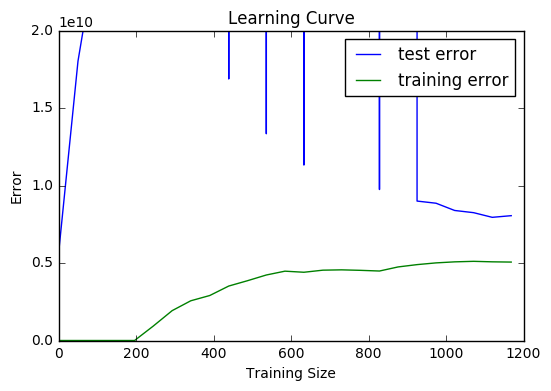

In [18]:
learning_curve(train_frac[features],
               train_frac[TARGET_VAR[0]],
               validation[features],
               validation[TARGET_VAR[0]],
               LinearRegression(),
               [0, 20000000000])

Happy with the mean squared error (the lower the better)? If yes, we can improve our model by using the entire 100% of our train_df.

In [19]:
linear_regression_model = LinearRegression() #(normalize=True)?
linear_regression_model.fit(train[features], train[TARGET_VAR[0]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now we can use this improved model to predict the housing prices of our test data.

In [20]:
predictions = linear_regression_model.predict(test_kaggle[features])
predictions.shape

(1459L,)

Due to a lack of a validation set, we are now no longer able to compute the mean squared error. But by uploading our predictions for the test set to Kaggle, we can get an even better sense of how good we're doing. This requires preparing a csv file according to Kaggle's requirements: one column with the ID, and one column with the predicted SalePrice. We create a function we can also reuse for other models than Linear Regression.

In [21]:
def export_csv(predictions, model):
    # Get the IDs from the indeces we earlier stored in test_df.
    ids = test_kaggle.index.values

    # Stack the IDs and predictions into a numpy array and transpose it into
    # vertical form.
    submission = np.vstack((ids, predictions)).T

    # Convert the submission array into a Pandas DataFrame object.
    submission = pd.DataFrame(data=submission, columns=['Id', 'SalePrice'])

    # Convert Id from float to int to avoid .0 notation.
    submission['Id'] = submission['Id'].astype(int)
    
    # Convert possible negative predicted values to 0
    submission[submission < 0] = 0

    # Print the shape of the newly created submission DataFrame.
    print 'Submission:', submission.shape
    
    # Export the submissions to a csv file.
    submission.to_csv('submission_' + model + '.csv', sept=',', index=False)

Now we can call the export_csv function to print our Linear Regression predictions to a csv file called submission_linear_regression.csv.

In [22]:
export_csv(predictions, 'linear_regression')

Submission: (1459, 2)


# Ridge Regression
Ridge regression is a linear regression model with regularization. The alpha value which determines the degree to which high weights are penalized in order to simplify the function and to avoid overfitting needs to be optimized.

In [23]:
# This list contains all the different values we want to test with
# our hyperparameter alpha.
alphas = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12,
          10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60,
          70, 80, 90, 100]

# Train a new Ridge regression model on the 100% train data while
# trying different values for alpha.
ridge_regression_model = RidgeCV(alphas=alphas)
ridge_regression_model.fit(train[features], train[TARGET_VAR[0]])

# Save optimal value for alpha in a variable for later use.
alpha = ridge_regression_model.alpha_
print 'alpha:', alpha

alpha: 11.0


In order to evaluate our model with the optimized alpha value, we print a learning curve which indicates if our model suffers from overfitting.

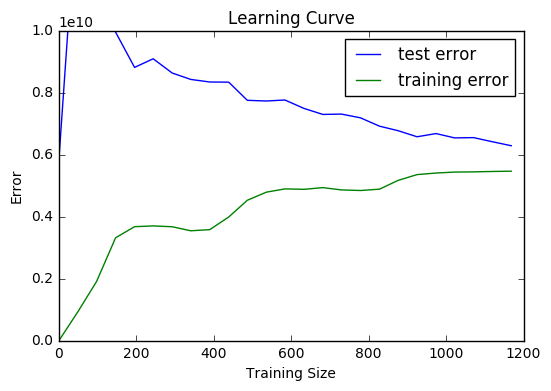

In [24]:
learning_curve(train_frac[features],
               train_frac[TARGET_VAR[0]],
               validation[features],
               validation[TARGET_VAR[0]],
               Ridge(alpha=alpha),
               [0, 10000000000])

If everything looks good, we can save our predictions to a csv file for submission to Kaggle.

In [25]:
predictions = ridge_regression_model.predict(test_kaggle[features])
export_csv(predictions, 'ridge_regression')

Submission: (1459, 2)


# Lasso Regression

In [26]:
# This list contains all the different values we want to test with
# our hyperparameter alpha.
alphas = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200,
          210, 220, 230, 240, 250, 260, 270]

# Train a new Lasso regression model on the 100% train data while
# trying different values for alpha.
lasso_regression_model = LassoCV(alphas=alphas)
lasso_regression_model.fit(train[features], train[TARGET_VAR[0]])

# Save optimal value for alpha in a variable for later use.
alpha = lasso_regression_model.alpha_
print 'alpha:', alpha

alpha: 140


C:\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


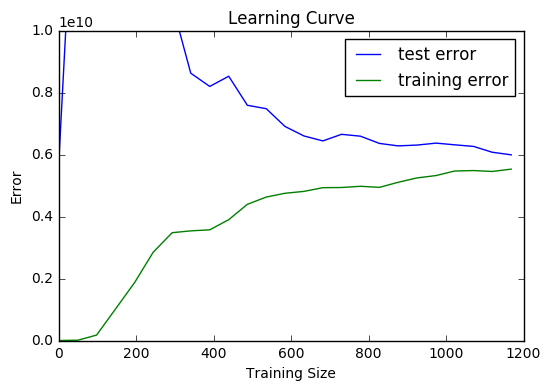

In [27]:
learning_curve(train_frac[features],
               train_frac[TARGET_VAR[0]],
               validation[features],
               validation[TARGET_VAR[0]],
               Lasso(alpha=alpha),
               [0, 10000000000])

In [28]:
predictions = lasso_regression_model.predict(test_kaggle[features])
export_csv(predictions, 'lasso_regression')

Submission: (1459, 2)


In [29]:
mixed_model_predictions_train["lasso"] = lasso_regression_model.predict(train[features])

# Random Forest Regressor
Now we can try out another method: Random Forest Regressor. In the following code block we optimize a few hyperparameters with a Grid Search.

In [30]:
# We set n_estimators to a fixed value upfront. There's no point in
# optimnizing it because it just represents a trade-off between
# prediction quality and computational cost: The higher the value
# the better the prediction but also the slower the computation.
n_estimators = 25

# We set n_jobs to -1 so that the number of used processors is not
# limited.
n_jobs = -1

# We set random_state to an arbitrary fixed value to make sure the
# results during testing are comparable.
random_state = 42

# Initialize the random forest model.
random_forest_model = RandomForestRegressor(n_estimators=n_estimators,
                                            random_state=random_state,
                                            n_jobs=n_jobs)

# This grid contains all the different values we want to test with
# our hyperparameters. The larger the grid, the longer the optimization
# takes because all possible combinations are tested.
param_grid = {"max_depth": [12, 13, 14, 15, 16],
              "max_features": [.1, .11, .12, .13],
              "min_samples_split": [3],
              "min_samples_leaf": [1],
              "bootstrap": [False]}

# Initialize the grid search with our random forest model and our
# parameter grid.
grid_search = GridSearchCV(estimator=random_forest_model,
                           param_grid=param_grid)

# Fit grid search to the training data.
grid_search.fit(train[features], train[TARGET_VAR[0]])

# Save the optimal values for the hyperparameters in new variables
# for later use.
max_depth = grid_search.best_estimator_.max_depth
max_features = grid_search.best_estimator_.max_features
min_samples_split = grid_search.best_estimator_.min_samples_split
min_samples_leaf = grid_search.best_estimator_.min_samples_leaf
bootstrap = grid_search.best_estimator_.bootstrap

# Show optimized values for our hyperparameters.
print 'max_depth:', max_depth
print 'max_features:', max_features
print 'min_samples_split:', min_samples_split
print 'min_samples_leaf:', min_samples_leaf
print 'bootstrap:', bootstrap
print 'n_jobs:', n_jobs

max_depth: 15
max_features: 0.12
min_samples_split: 3
min_samples_leaf: 1
bootstrap: False
n_jobs: -1


Now we can fit the model to our 100% train dataset, predict the values for Kaggle's test dataset, and export the results into a csv file.

In [31]:
n_estimators = 150

random_forest_model = RandomForestRegressor(
    random_state=random_state,
    n_estimators=n_estimators,
    max_features=max_features,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    bootstrap=bootstrap,
    n_jobs=n_jobs
)

random_forest_model.fit(train[features], train[TARGET_VAR[0]])
print random_forest_model
predictions = random_forest_model.predict(test_kaggle[features])
export_csv(predictions, 'random_forest_regressor')

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=15,
           max_features=0.12, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
Submission: (1459, 2)


In [32]:
mixed_model_predictions_train["random_forest"] = random_forest_model.predict(train[features])

# AdaBoost

AdaBoost combines multiple iterations of a weak learner, weights the results, and ultimately outputs reasonable predictions. We use a shallow Random Forest model as weak learner. In the following codeblock, we optimize the hyperparameters.

In [33]:
# We set random_state to an arbitrary fixed value to make sure the
# results during testing are comparable.
random_state = 42

# We set n_jobs to -1 so that the number of used processors is not
# limited.
n_jobs = -1

# Initialize our weak learner, a random forest regressor.
decision_tree_model = DecisionTreeRegressor()

# Initialize AdaBoost model with random forest as weak learner.
adaboost_model = AdaBoostRegressor(base_estimator=decision_tree_model,
                                   random_state=random_state)

# This grid contains all the different values we want to test with
# our hyperparameters. The larger the grid, the longer the optimization
# takes because all possible combinations are tested.
param_grid = {"n_estimators": [106, 107, 108],
              "base_estimator__max_depth": [21, 22, 23, 24, 25],
              "base_estimator__max_features": [.37, .38, .39, .4, .41],
              "base_estimator__min_samples_split": [1],
              "base_estimator__min_samples_leaf": [2]}

# Initialize the grid search with our AdaBoost model and our
# parameter grid.
grid_search = GridSearchCV(estimator=adaboost_model,
                           param_grid=param_grid)

# Fit grid search to the training data.
grid_search.fit(train[features], train[TARGET_VAR[0]])

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=42),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [106, 107, 108], 'base_estimator__min_samples_split': [1], 'base_estimator__max_depth': [21, 22, 23, 24, 25], 'base_estimator__min_samples_leaf': [2], 'base_estimator__max_features': [0.37, 0.38, 0.39, 0.4, 0.41]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [34]:
# Save the optimal values for the hyperparameters in new variables
# for later use.
n_estimators = grid_search.best_estimator_.n_estimators
base_estimator__max_depth = grid_search.best_estimator_.base_estimator.max_depth
base_estimator__max_features = grid_search.best_estimator_.base_estimator.max_features
base_estimator__min_samples_split = grid_search.best_estimator_.base_estimator.min_samples_split
base_estimator__min_samples_leaf = grid_search.best_estimator_.base_estimator.min_samples_leaf

# Show optimized values for our hyperparameters.
print 'n_estimators:', n_estimators # 107
print 'base_estimator__max_depth:', base_estimator__max_depth # 22
print 'base_estimator__max_features:', base_estimator__max_features # .4
print 'base_estimator__min_samples_split:', base_estimator__min_samples_split # 1
print 'base_estimator__min_samples_leaf:', base_estimator__min_samples_leaf #2

n_estimators: 107
base_estimator__max_depth: 22
base_estimator__max_features: 0.4
base_estimator__min_samples_split: 1
base_estimator__min_samples_leaf: 2


Finally, we run another AdaBoost regressor with the optimized hyperparameters on the Kaggle test dataset and export our predictions into a csv file.

In [35]:
decision_tree_model = DecisionTreeRegressor(
    max_depth=base_estimator__max_depth,
    max_features=base_estimator__max_features,
    min_samples_split=base_estimator__min_samples_split,
    min_samples_leaf=base_estimator__min_samples_leaf
)

adaboost_model = AdaBoostRegressor(
    base_estimator=decision_tree_model,
    random_state=random_state,
    n_estimators=n_estimators
)

adaboost_model.fit(train[features], train[TARGET_VAR[0]])
predictions = adaboost_model.predict(test_kaggle[features])
export_csv(predictions, 'adaboost')
print adaboost_model

Submission: (1459, 2)
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=22, max_features=0.4,
           max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=1,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=107,
         random_state=42)


In [36]:
mixed_model_predictions_train["adaboost"] = adaboost_model.predict(train[features])

# Mixed Model: Average
Now we take the average of all our comparably good models to make a prediction which is, hopefully, even better as it balances out the different biases.

In [37]:
# Store predictions of the different models in DataFrame objects.
lasso = pd.read_csv('submission_lasso_regression.csv')
random_forest = pd.read_csv('submission_random_forest_regressor.csv')
adaboost = pd.read_csv('submission_adaboost.csv')

# Set columns indices.
lasso.set_index('Id', inplace=True)
random_forest.set_index('Id', inplace=True)
adaboost.set_index('Id', inplace=True)

# Rename columns
lasso.columns = ['lasso']
random_forest.columns = ['random_forest']
adaboost.columns = ['adaboost']

# Merge model predictions into one DataFrame object.
mixed_model_predictions_test = pd.concat([adaboost, lasso, random_forest], axis=1)

# Calculate mean values of the models' predictions.
predictions = mixed_model_predictions_test.mean(axis=1).as_matrix()

# Export mean predictions to a csv submission file.
export_csv(predictions, 'mixed_mean')

Submission: (1459, 2)


# Mixed Model: Linear Regression
The mixed model above simply used the average of our different models' predictions. However, this does not take into account the different biases of our models. Consequently, we now calculate a linear regression with the different model predictions for our training examples as features and the actual SalePrices as target variable. This way, we can calculate weights which we can use to control the weighted influence of each model's predictions on the final predictions of the mixed model.

In [38]:
# Add the actual SalePrice of the train data to the DataFrame
# containing the train data predictions of our various models.
mixed_model_predictions_train['SalePrice'] = train[TARGET_VAR].as_matrix()

# Run a linear regression to determine weights for our different
# model predictions.
linear_regression_model = LinearRegression()
linear_regression_model.fit(
    mixed_model_predictions_train[["lasso", "random_forest", "adaboost"]],
    mixed_model_predictions_train[TARGET_VAR[0]]
)

# Predict the mixed model SalePrices based on the weighted models.
predictions = linear_regression_model.predict(mixed_model_predictions_test)

# Export to csv.
export_csv(predictions, 'mixed_regression')

Submission: (1459, 2)


This table can be used in the report for clarification. It contains the predictions of our single models on the Kaggle test set as well as the final weighted predictions based on the linear regression.

In [39]:
mixed_model_predictions_test["SalePrice"] = predictions
del mixed_model_predictions_test['SalePrice']
print mixed_model_predictions_test

           adaboost          lasso  random_forest
Id                                               
1461  128950.000000  116292.269047  130202.587653
1462  154950.000000  158441.205394  152557.584984
1463  175500.000000  175575.635557  183620.283991
1464  190000.000000  196097.642226  196868.811188
1465  196800.000000  211851.339703  195210.473739
1466  179950.000000  166377.335866  179508.450409
1467  172200.000000  184780.072542  176809.659683
1468  177666.666667  167078.706459  178214.153172
1469  179821.666667  200972.942237  185575.561462
1470  125500.000000  106057.263932  127481.934482
1471  211075.000000  184882.832589  215122.643949
1472   97500.000000  108008.343298   96231.107990
1473  101000.000000   97681.932898  103466.953369
1474  150600.000000  149047.324054  151276.045805
1475  141250.000000  103296.739422  124163.967177
1476  378500.000000  364459.110722  371576.774444
1477  255250.000000  251360.687508  248911.213973
1478  315166.666667  320917.274644  312033.687729


# Mixed Model: Random Forest

The mixed model with linear regression worked great. Doing the same with a more advanced regressor – random forest – might improve the results even further.

In [40]:
# We set n_estimators to a fixed value upfront.
n_estimators = 25

# We set n_jobs to -1 so that the number of used processors is not
# limited.
n_jobs = -1

# We set random_state to an arbitrary fixed value to make sure the
# results during testing are comparable.
random_state = 42

# Initialize the random forest model.
random_forest_model = RandomForestRegressor(n_estimators=n_estimators,
                                            random_state=random_state,
                                            n_jobs=n_jobs)

# This grid contains all the different values we want to test with
# our hyperparameters. The larger the grid, the longer the optimization
# takes because all possible combinations are tested.
param_grid = {"max_depth": [15, 16, 17, 18, 19, 20],
              "max_features": [2],
              "min_samples_split": [1],
              "min_samples_leaf": [1],
              "bootstrap": [False]}

# Initialize the grid search with our random forest model and our
# parameter grid.
grid_search = GridSearchCV(estimator=random_forest_model,
                           param_grid=param_grid)

# Fit grid search to the model predictions.
grid_search.fit(
    mixed_model_predictions_train[["lasso", "random_forest", "adaboost"]],
    mixed_model_predictions_train[TARGET_VAR[0]]
)

# Save the optimal values for the hyperparameters in new variables
# for later use.
max_depth = grid_search.best_estimator_.max_depth
max_features = grid_search.best_estimator_.max_features
min_samples_split = grid_search.best_estimator_.min_samples_split
min_samples_leaf = grid_search.best_estimator_.min_samples_leaf
bootstrap = grid_search.best_estimator_.bootstrap

# Show optimized values for our hyperparameters.
print 'max_depth:', max_depth
print 'max_features:', max_features
print 'min_samples_split:', min_samples_split
print 'min_samples_leaf:', min_samples_leaf
print 'bootstrap:', bootstrap
print 'n_jobs:', n_jobs

max_depth: 20
max_features: 2
min_samples_split: 1
min_samples_leaf: 1
bootstrap: False
n_jobs: -1


Now we can fit the model to our model predictions again, predict the final mixed SalePrices for Kaggle's test dataset, and export the results into a csv file.

In [41]:
random_forest_model = RandomForestRegressor(
    random_state=random_state,
    n_estimators=n_estimators,
    max_features=max_features,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    bootstrap=bootstrap,
    n_jobs=n_jobs
)

random_forest_model.fit(
    mixed_model_predictions_train[["lasso", "random_forest", "adaboost"]],
    mixed_model_predictions_train[TARGET_VAR[0]]
)
predictions = random_forest_model.predict(mixed_model_predictions_test)
export_csv(predictions, 'mixed_random_forest')

Submission: (1459, 2)


Turns out: This didn't help. The mixed model with linear regression worked better.